<a href="https://colab.research.google.com/github/aida-am247/Deep-Learning/blob/master/E1/DL_E1_best_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset.py
!mkdir dataset
!wget https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/raw/master/dataset/Data_hoda_full.mat -P dataset

--2020-09-22 15:09:33--  https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929 [text/plain]
Saving to: ‘dataset.py’

dataset.py          100%[===================>]     929  --.-KB/s    in 0s      

2020-09-22 15:09:33 (52.0 MB/s) - ‘dataset.py’ saved [929/929]

--2020-09-22 15:09:34--  https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/raw/master/dataset/Data_hoda_full.mat
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset/Data_hoda_full.mat [foll

In [2]:
# import the necessary packages
from keras.callbacks import LambdaCallback
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta

		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []

		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "Iterator", "Sequence"]

		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)

		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)

		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss

		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return

		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth

		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()

		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)

		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)

		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))

		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

		# compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch

		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)

		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)

		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))

		# check to see if we are using a data iterator
		if useGen:
			self.model.fit_generator(
				trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])

		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				trainData[0], trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)

		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]

		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")

		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from dataset import load_hoda
import datetime

In [4]:
np.random.seed(123)  # for reproducibility

# Load pre-shuffled HODA data into train and test sets
x_train_original, y_train_original, x_test_original, y_test_original = load_hoda(
                                                                        training_sample_size=3500, test_sample_size=400,size=28)

# Preprocess input data
''' 3.1: input data in numpy array format'''
x_train = np.array(x_train_original)
x_test = np.array(x_test_original)
'''3.2 normalize our data values to the range [0, 1]'''
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Reshape to original image shape (n x 784)  ==> (n x 28 x 28 x 1)
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


# Preprocess class labels
y_train = keras.utils.to_categorical(y_train_original, num_classes=10)
y_test = keras.utils.to_categorical(y_test_original, num_classes=10)


# test and validation set
x_val = x_test[:200]
x_test = x_test[200:]
y_val = y_test[:200]
y_test = y_test[200:]

In [5]:
# Define model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# Fit model on training data
history = model.fit(x_train, y_train,
          epochs=200, batch_size=256, validation_data = (x_val, y_val))

Epoch 1/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0101 - accuracy: 0.9960 - val_loss: 0.0876 - val_accuracy: 0.9850
Epoch 2/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0112 - accuracy: 0.9963 - val_loss: 0.1104 - val_accuracy: 0.9850
Epoch 3/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.1256 - val_accuracy: 0.9800
Epoch 4/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.1391 - val_accuracy: 0.9800
Epoch 5/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.1138 - val_accuracy: 0.9800
Epoch 6/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.1232 - val_accuracy: 0.9800
Epoch 7/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.1102 - val_accuracy: 0.9850
Epoch 8/200


Epoch 1/19
110/110 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 0.9983
Epoch 2/19
110/110 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 0.9974
Epoch 3/19
110/110 [==============================] - 0s 4ms/step - loss: 0.0054 - accuracy: 0.9969
Epoch 4/19
110/110 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 0.9983
Epoch 5/19
110/110 [==============================] - 0s 4ms/step - loss: 0.0074 - accuracy: 0.9980


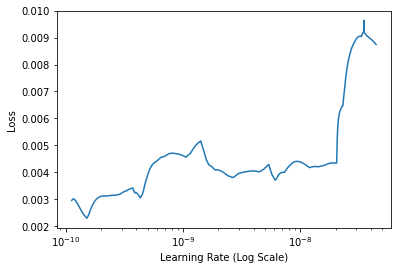

In [14]:
# initialize the learning rate finder and then train with learning
lrf = LearningRateFinder(model)
lrf.find((x_train, y_train),1e-10, 1e+1)
# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()